In [1]:
import sys
from os import listdir
from os.path import isfile, join
import pandas as pd
#!{sys.executable} -m pip install tensorflow-gpu==2.4
!export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/home/bhawks/.conda/envs/dune-1dcnn/lib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras 
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [2]:
from tqdm import trange

# Load data, select ADC

In [3]:
wireplane = "Z"
sig_name = wireplane+"-signal"
cln_name = wireplane+"-clnsig"
np.random.seed(42)
nticks = 200
max_mels = 11000
min_edp = 50000
ADC_MIN = 3
ADC_MAX = 10
waveform_scaler = StandardScaler()

def extract_wave(data):
    string = 'tck_'
    waveforms = []
    #Here I extract a column in each iteration and append to list
    for i in range(nticks):
        waveforms.append(data[string+str(i)].astype(np.int16))
    #convert to numpy ndarray
    waveforms = np.array(waveforms).astype(np.int16)
    #since raws and columns are inverted we need to transpose it
    return np.transpose(waveforms)

def extract_peak(data):
    #extract index of peak
    idx = np.array([data['stp0'], data['adc0'], data['stp1'], data['adc1'], data['stp2'], data['adc2'], data['stp3'], data['adc3'], data['stp4'], data['adc4']])
    #same as before
    return np.transpose(idx)

def extract_peak_info(data):
    peaks_pos = [data['stp0'], data['stp1'], data['stp2'], data['stp3'], data['stp4']]
    adcs = [data['adc0'], data['adc1'], data['adc2'], data['adc3'], data['adc4']]
    return np.array(peaks_pos).T, np.array(adcs).T

def extract_nel_info(data):
    nels = [data['nel0'], data['nel1'], data['nel2'], data['nel3'], data['nel4']]
    return np.array(nels).T

def extract_edp_info(data):
    edp = [data['edp0'], data['edp1'], data['edp2'], data['edp3'], data['edp4']]
    return np.array(edp).T

def filter_signals(data, clean_data, filter_adc_max=True):
    #edp_mask = np.all(extract_edp_info(data)>min_edp, axis = 1)
    #nel_mask = np.all(extract_nel_info(data)<max_mels, axis = 1)
    #pd.DataFrame(np.all(extract_edp_info(data)>min_edp, axis = 1)).describe()
    #print(edp_mask)
    #print(nel_mask)
    #filter_mask = nel_mask #np.logical_and(edp_mask,nel_mask) 
    filtered_data = data#[filter_mask]
    cln_filtered_data = clean_data#[filter_mask]
    
    filtered_peak = extract_peak_info(cln_filtered_data)[1]
    if filter_adc_max:
        peak_mask = np.any(filtered_peak>ADC_MIN, axis = 1)
        peak_mask &= np.any(filtered_peak<ADC_MAX, axis = 1)
    else:
        peak_mask = np.any(filtered_peak>ADC_MIN, axis = 1)
    
    filtered_data = filtered_data[peak_mask]
    cln_filtered_data = cln_filtered_data[peak_mask]
    
    return filtered_data, cln_filtered_data, filtered_peak

def get_std_waveforms(data):
    #Extract and scale waveform data (passthrough rn)
    raw_waveforms = extract_wave(data)
    #print(raw_waveforms) 
    #scaled_waveforms = waveform_scaler.fit_transform(raw_waveforms)
    return raw_waveforms

In [4]:
#X = np.load("data/X_argoneut.npz")
#y = np.load("data/y_argoneut.npz")
#old_peak = np.load("peak_argoneut.npz")

#Load Training Data
path = "/home/bhawks/dunesnb/1dcnn/train/train/nu_cc/"
path2 = "/home/bhawks/dunesnb/1dcnn/train/train/nu_es/"
filenames1 = [path+f for f in listdir(path) if (isfile(join(path, f)) and sig_name in f)]
clean_filenames1 = [path+f for f in listdir(path) if (isfile(join(path, f)) and cln_name in f)]
filenames2 = [path2+f for f in listdir(path2) if (isfile(join(path2, f)) and sig_name in f)]
clean_filenames2 = [path2+f for f in listdir(path2) if (isfile(join(path2, f)) and cln_name in f)]

filenames =  filenames1+filenames2
clean_filenames = clean_filenames1+clean_filenames2

combined_data = np.concatenate([np.load(fname) for fname in filenames])
combined_clean_data = np.concatenate([np.load(fname) for fname in filenames])

noise_path = "/home/bhawks/dunesnb/1dcnn/train/train/noise/"
noise_filenames = [f for f in listdir(noise_path) if (isfile(join(noise_path, f)) and sig_name in f)]
#print(noise_filenames)
noise_clean_filenames = [f for f in listdir(noise_path) if (isfile(join(noise_path, f)) and cln_name in f)]

combined_noise = np.concatenate([np.load(noise_path+fname) for fname in noise_filenames])
#print(combined_noise)
#combined_clean_noise = np.concatenate([np.load(noise_path+fname) for fname in noise_clean_filenames])



# Train/Noise Data Preprocessing



In [5]:
from sklearn.utils import shuffle
print(combined_data.shape[0])
#Filter out tiny signals < ADC_MIN, but leave big signals to test on (> ADC_MAX)
combined_data, combined_clean_data, peak = filter_signals(combined_data, combined_clean_data, False)
print(combined_data.shape[0])

#split train and test sets (~50k ea before filtering) 
combined_data, x_test_data, combined_clean_data, x_test_clean  = train_test_split(
    combined_data, combined_clean_data, test_size=0.5, shuffle=True
)
print(combined_data.shape[0])
#filter data and extract waveforms of filtered data
combined_data, combined_clean_data, peak = filter_signals(combined_data, combined_clean_data, True)
signal_waveforms = get_std_waveforms(combined_data)
print(combined_data.shape[0])
#extract waveforms of noise
noise_waveforms = get_std_waveforms(combined_noise)

#extract waveforms of test data
test_signal_waveforms = get_std_waveforms(x_test_data)
print(test_signal_waveforms.shape[0])
#generate y data (assuming all radiologicals contain signal, all noise does not)
y_noise_full = np.zeros(noise_waveforms.shape[0])
y_signal = np.ones(signal_waveforms.shape[0])
y_test_signal = np.ones(test_signal_waveforms.shape[0])


# split test and train noise datasets (50k)
x_noise_train, x_noise_test, y_noise_train, y_noise_test = train_test_split(
    noise_waveforms, y_noise_full, test_size=0.5, shuffle=True
)

#Shuffle signal waveforms to be safe
signal_waveforms, y_signal = shuffle(signal_waveforms,y_signal)

#Shuffle test waveformst to be safe
x_test, y_test = shuffle(test_signal_waveforms,y_test_signal)

#Select First n signal samples from (shuffled) set of signals where n = noise samples for balanced train set 
x_train = np.concatenate((signal_waveforms[:int(x_noise_train.shape[0])], x_noise_train))
y_train = np.concatenate((y_signal[:int(x_noise_train.shape[0])], y_noise_train))

x_test = np.concatenate((x_test[:int(x_noise_test.shape[0])], x_noise_test))
y_test = np.concatenate((y_test_signal[:int(x_noise_test.shape[0])], y_noise_test))


# extra train shuffle for good measure 
x_train, y_train = shuffle(x_train,y_train)

# extra test shuffle for good measure 
x_test, y_test = shuffle(x_test,y_test)

#split train and valid sets (40k train 10k valid) 
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train, y_train, test_size=0.2, shuffle=True
)

210996
128926
64463
59166
64463


# Load Test Data

In [6]:
'''
#Load Test Data
cc_path = "/home/bhawks/dunesnb/1dcnn/train/train/nu_cc/"
cc_filenames = [f for f in listdir(cc_path) if (isfile(join(cc_path, f)) and sig_name in f)]
cc_clean_filenames = [f for f in listdir(cc_path) if (isfile(join(cc_path, f)) and cln_name in f)]

es_path = "/home/bhawks/dunesnb/1dcnn/train/train/nu_es/"
es_filenames = [f for f in listdir(es_path) if (isfile(join(es_path, f)) and sig_name in f)]
es_clean_filenames = [f for f in listdir(es_path) if (isfile(join(es_path, f)) and cln_name in f)]

cc_combined_data = np.concatenate([np.load(cc_path+fname) for fname in cc_filenames])
es_combined_data = np.concatenate([np.load(es_path+fname) for fname in es_filenames])

cc_combined_clean_data = np.concatenate([np.load(cc_path+fname) for fname in cc_filenames])
es_combined_clean_data= np.concatenate([np.load(es_path+fname) for fname in es_filenames])
'''

'\n#Load Test Data\ncc_path = "/home/bhawks/dunesnb/1dcnn/train/train/nu_cc/"\ncc_filenames = [f for f in listdir(cc_path) if (isfile(join(cc_path, f)) and sig_name in f)]\ncc_clean_filenames = [f for f in listdir(cc_path) if (isfile(join(cc_path, f)) and cln_name in f)]\n\nes_path = "/home/bhawks/dunesnb/1dcnn/train/train/nu_es/"\nes_filenames = [f for f in listdir(es_path) if (isfile(join(es_path, f)) and sig_name in f)]\nes_clean_filenames = [f for f in listdir(es_path) if (isfile(join(es_path, f)) and cln_name in f)]\n\ncc_combined_data = np.concatenate([np.load(cc_path+fname) for fname in cc_filenames])\nes_combined_data = np.concatenate([np.load(es_path+fname) for fname in es_filenames])\n\ncc_combined_clean_data = np.concatenate([np.load(cc_path+fname) for fname in cc_filenames])\nes_combined_clean_data= np.concatenate([np.load(es_path+fname) for fname in es_filenames])\n'

# Test Data Pre-Processing

In [7]:
'''
cc_combined_data, cc_combined_clean_data, cc_peak = filter_signals(cc_combined_data, cc_combined_clean_data)
es_combined_data, es_combined_clean_data, es_peak = filter_signals(es_combined_data, es_combined_clean_data)

cc_signal_waveforms = get_std_waveforms(cc_combined_data)
es_signal_waveforms = get_std_waveforms(es_combined_data)

cc_y_signal = np.ones(cc_signal_waveforms.shape[0])
es_y_signal = np.ones(es_signal_waveforms.shape[0])

#Select First n signal samples from (shuffled) set of signals where n = noise samples for balanced test 
cc_x_test = np.concatenate((cc_signal_waveforms[:int(x_noise_test.shape[0])], x_noise_test))
cc_y_test = np.concatenate((cc_y_signal[:int(x_noise_test.shape[0])], y_noise_test))

#Select First n signal samples from (shuffled) set of signals where n = noise samples for balanced test 
es_x_test = np.concatenate((es_signal_waveforms[:int(x_noise_test.shape[0])], x_noise_test))
es_y_test = np.concatenate((es_y_signal[:int(x_noise_test.shape[0])], y_noise_test))

#shuffle for good measure 
from sklearn.utils import shuffle
cc_x_test, cc_y_test = shuffle(cc_x_test,cc_y_test)
es_x_test, es_y_test = shuffle(es_x_test,es_y_test)
'''

'\ncc_combined_data, cc_combined_clean_data, cc_peak = filter_signals(cc_combined_data, cc_combined_clean_data)\nes_combined_data, es_combined_clean_data, es_peak = filter_signals(es_combined_data, es_combined_clean_data)\n\ncc_signal_waveforms = get_std_waveforms(cc_combined_data)\nes_signal_waveforms = get_std_waveforms(es_combined_data)\n\ncc_y_signal = np.ones(cc_signal_waveforms.shape[0])\nes_y_signal = np.ones(es_signal_waveforms.shape[0])\n\n#Select First n signal samples from (shuffled) set of signals where n = noise samples for balanced test \ncc_x_test = np.concatenate((cc_signal_waveforms[:int(x_noise_test.shape[0])], x_noise_test))\ncc_y_test = np.concatenate((cc_y_signal[:int(x_noise_test.shape[0])], y_noise_test))\n\n#Select First n signal samples from (shuffled) set of signals where n = noise samples for balanced test \nes_x_test = np.concatenate((es_signal_waveforms[:int(x_noise_test.shape[0])], x_noise_test))\nes_y_test = np.concatenate((es_y_signal[:int(x_noise_test.s

In [8]:
#pd.DataFrame(extract_nel_info(combined_data)).describe()

In [9]:
#pd.DataFrame(old_peak["training_set"]).describe()


In [10]:
#for i in range(0,5): 
#    plt.hist(peak[:,i],bins=120)
#    plt.show()
#pd.DataFrame(peak).describe()

In [11]:
#for i in range(0,5): 
#    plt.hist(unscaled_peak[:,i],bins=120)
#    plt.show()
#pd.DataFrame(unscaled_peak).describe()

In [12]:
#x_train = X["training_set"]
#y_train = y["training_set"]#
#x_test = X["test_set"]
#y_test = y["test_set"]

#peak_train = peak["training_set"]
#peak_test = peak["test_set"]
#del y
#del X
#del peak

In [13]:
#ADC_MIN = 3

In [14]:
#signal = x_train[y_train == 1]
#noise = x_train[y_train == 0]

#peak_signal = peak_train[y_train == 1]
#peak_noise =  peak_train[y_train == 0]

In [15]:
#signal_test = x_test[y_test == 1]
#noise_test = x_test[y_test == 0]

#peak_signal_test = peak_test[y_test == 1]
#peak_noise_test =  peak_test[y_test == 0]

In [16]:
#mask = np.any(peak_signal>ADC_MIN, axis = 1)
#peak_signal = signal[mask]
#signal = signal[mask]

In [17]:
#mask = np.any(peak_signal_test>ADC_MIN, axis = 1)
#peak_signal_test = signal_test[mask]
#signal_test = signal_test[mask]

In [18]:
#y_noise = np.zeros(signal.shape[0])
#y_signal = np.ones(signal.shape[0])

#x_train = np.concatenate((noise[:signal.shape[0]], signal))
#y_train = np.concatenate((y_noise, y_signal))
#from sklearn.utils import shuffle
#x_train, y_train = shuffle(x_train,y_train)

In [19]:
#y_noise_test = np.zeros(signal_test.shape[0])
#y_signal_test = np.ones(signal_test.shape[0])

#x_test = np.concatenate((noise_test[:signal_test.shape[0]], signal_test))
#y_test = np.concatenate((y_noise_test, y_signal_test))
#from sklearn.utils import shuffle
#x_test, y_test = shuffle(x_test,y_test)

In [20]:
x_train.shape

(86880, 200)

In [21]:
x_valid.shape

(21720, 200)

In [22]:
mean = x_train.mean()
std = x_train.std()

In [23]:
x_train_scaled = (x_train-mean)/std
x_valid_scaled = (x_valid-mean)/std
x_test_scaled = (x_test-mean)/std
#cc_x_test_scaled = (cc_x_test-mean)/std 
#es_x_test_scaled = (es_x_test-mean)/std 
time_periods = 200

In [24]:
np.save("models/mean_z_nu", mean)
np.save("models/scale_z_nu", std)

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, \
    Dropout, Dense,Flatten, AveragePooling1D, BatchNormalization

In [26]:
time_periods = 200
def create_model():
  model = Sequential()  
  #first convolutional block
  model.add(Conv1D(filters=16, kernel_size=3, strides=2, activation = "relu", input_shape=(time_periods,1)))
  model.add(MaxPooling1D(pool_size=2))

  #second convolutional block
  model.add(Conv1D(filters=32, kernel_size=5, strides=2, activation = "relu"))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Dropout(0.1))
  
  #forth convolutional block
  model.add(Conv1D(filters=64, kernel_size=9, activation = "relu"))
  model.add(GlobalMaxPooling1D())
  model.add(Dropout(0.2)) 
    
  model.add(Flatten())
  model.add(Dense(1, activation="sigmoid", name="wavrec_out"))
  return model


model = create_model()

#lr=0.001
adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(optimizer = adam, loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 99, 16)            64        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 49, 16)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 23, 32)            2592      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 11, 32)            0         
_________________________________________________________________
dropout (Dropout)            (None, 11, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 3, 64)             18496     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0

2022-02-17 16:54:07.758482: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [27]:
x_train_scaled = x_train_scaled.reshape(x_train_scaled.shape[0], x_train_scaled.shape[1], 1)
#cc_x_test_scaled = cc_x_test_scaled.reshape(cc_x_test_scaled.shape[0], cc_x_test_scaled.shape[1], 1)
#es_x_test_scaled = es_x_test_scaled.reshape(es_x_test_scaled.shape[0], es_x_test_scaled.shape[1], 1)
x_valid_scaled = x_valid_scaled.reshape(x_valid_scaled.shape[0], x_valid_scaled.shape[1], 1)
x_test_scaled = x_test_scaled.reshape(x_test_scaled.shape[0], x_test_scaled.shape[1], 1)

In [28]:
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)


In [29]:
%%time
history = model.fit(x_train_scaled,                                                              
                    y_train,                                                            
                    batch_size=2048,                                              
                    epochs=100,      
                    
                   # epochs=30, 
                    #epochs = 6,
                    callbacks=[earlystop],
                     # callbacks=callbacks_list,                         
                    validation_data=(x_valid_scaled, y_valid),                                               
                    verbose=1)   

2022-02-17 16:54:08.081842: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-02-17 16:54:08.082562: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2199995000 Hz


Epoch 1/100
43/43 [==============================] - 4s 76ms/step - loss: 0.5863 - accuracy: 0.6226 - val_loss: 0.3199 - val_accuracy: 0.8724
Epoch 2/100
43/43 [==============================] - 2s 53ms/step - loss: 0.3018 - accuracy: 0.8756 - val_loss: 0.2613 - val_accuracy: 0.8930
Epoch 3/100
43/43 [==============================] - 2s 52ms/step - loss: 0.2573 - accuracy: 0.8968 - val_loss: 0.2456 - val_accuracy: 0.9001
Epoch 4/100
43/43 [==============================] - 2s 52ms/step - loss: 0.2438 - accuracy: 0.9036 - val_loss: 0.2391 - val_accuracy: 0.9031
Epoch 5/100
43/43 [==============================] - 2s 55ms/step - loss: 0.2395 - accuracy: 0.9046 - val_loss: 0.2360 - val_accuracy: 0.9061
Epoch 6/100
43/43 [==============================] - 2s 50ms/step - loss: 0.2371 - accuracy: 0.9062 - val_loss: 0.2343 - val_accuracy: 0.9074
Epoch 7/100
43/43 [==============================] - 2s 51ms/step - loss: 0.2363 - accuracy: 0.9070 - val_loss: 0.2328 - val_accuracy: 0.9076
Epoch 

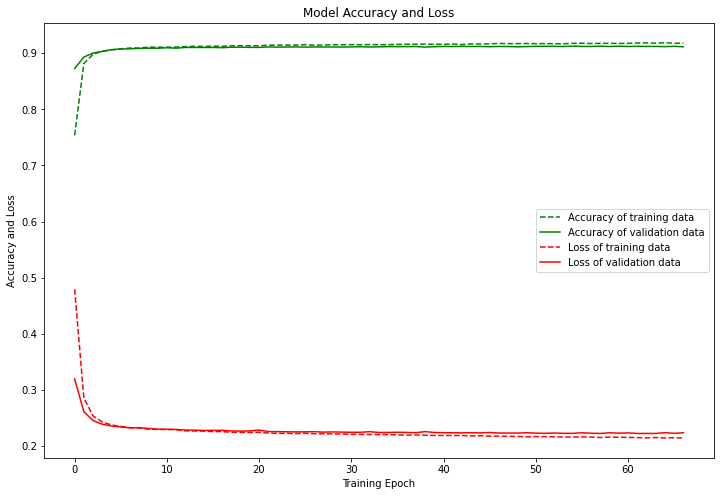

In [30]:
plt.figure(figsize=(12, 8))                                                     
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data", antialiased=True)
plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data", antialiased=True)
plt.plot(history.history['loss'], "r--", label="Loss of training data", antialiased=True)
plt.plot(history.history['val_loss'], "r", label="Loss of validation data", antialiased=True)
plt.title('Model Accuracy and Loss')                                            
plt.ylabel('Accuracy and Loss')                                                 
plt.xlabel('Training Epoch')                                                    
#plt.ylim(0)                                                                     
plt.legend()                                                                    
plt.show()     

In [31]:
#del x_train

import gc
gc.collect()

5629

In [32]:
model.save("models/zplane_nu.h5")

In [33]:
history.history['loss']

[0.4793231189250946,
 0.2854997217655182,
 0.25402653217315674,
 0.24307222664356232,
 0.23780794441699982,
 0.23533131182193756,
 0.23301273584365845,
 0.23244048655033112,
 0.23034006357192993,
 0.22993940114974976,
 0.2298373579978943,
 0.22931155562400818,
 0.22733187675476074,
 0.22718802094459534,
 0.2268686592578888,
 0.22604429721832275,
 0.22594612836837769,
 0.22490519285202026,
 0.22473901510238647,
 0.22446444630622864,
 0.22486995160579681,
 0.22341354191303253,
 0.22282375395298004,
 0.2229609340429306,
 0.2225019931793213,
 0.2229560911655426,
 0.22226983308792114,
 0.22209841012954712,
 0.22197584807872772,
 0.22168003022670746,
 0.22121624648571014,
 0.22096888720989227,
 0.22079876065254211,
 0.22070974111557007,
 0.2206130474805832,
 0.2201855480670929,
 0.21970675885677338,
 0.2200595736503601,
 0.2194165587425232,
 0.2191362828016281,
 0.2191993147134781,
 0.21903851628303528,
 0.21901379525661469,
 0.21840637922286987,
 0.21864767372608185,
 0.21780091524124146,
 

In [34]:
history.history['val_loss']

[0.3198644518852234,
 0.26131731271743774,
 0.24561771750450134,
 0.2391151785850525,
 0.23597827553749084,
 0.23427852988243103,
 0.23279744386672974,
 0.23298397660255432,
 0.2316385954618454,
 0.23028935492038727,
 0.23014505207538605,
 0.22992216050624847,
 0.22885800898075104,
 0.22859086096286774,
 0.2281356155872345,
 0.22821404039859772,
 0.22821079194545746,
 0.2271791398525238,
 0.2268935739994049,
 0.22731906175613403,
 0.22880131006240845,
 0.22612828016281128,
 0.22592227160930634,
 0.22568848729133606,
 0.22546356916427612,
 0.22557595372200012,
 0.22585132718086243,
 0.22508126497268677,
 0.22546404600143433,
 0.22504597902297974,
 0.2247859388589859,
 0.2248539924621582,
 0.22585618495941162,
 0.22445650398731232,
 0.22449013590812683,
 0.2248380333185196,
 0.22456003725528717,
 0.22408366203308105,
 0.22603973746299744,
 0.224397674202919,
 0.22410544753074646,
 0.2238827347755432,
 0.22378599643707275,
 0.22399389743804932,
 0.2237517386674881,
 0.22439874708652496,
 

In [35]:
history.history['accuracy']

[0.7536256909370422,
 0.8815147280693054,
 0.8980202674865723,
 0.9032918810844421,
 0.9057781100273132,
 0.9075852036476135,
 0.9090124368667603,
 0.9091275334358215,
 0.9105778336524963,
 0.910531759262085,
 0.9105662703514099,
 0.9107734560966492,
 0.911544680595398,
 0.9120510816574097,
 0.9119129776954651,
 0.9123503565788269,
 0.9121086597442627,
 0.912960410118103,
 0.9131560921669006,
 0.9131790995597839,
 0.9131330847740173,
 0.9140883684158325,
 0.9142150282859802,
 0.9142610430717468,
 0.9141919612884521,
 0.9150667786598206,
 0.9140193462371826,
 0.9144222140312195,
 0.9149516820907593,
 0.9149286150932312,
 0.9150897860527039,
 0.9149631857872009,
 0.9152163863182068,
 0.9150092005729675,
 0.9150897860527039,
 0.9154811501502991,
 0.9157228469848633,
 0.9157803654670715,
 0.9161257147789001,
 0.9156652688980103,
 0.9155962467193604,
 0.9161487221717834,
 0.9152278900146484,
 0.9162753224372864,
 0.9161832332611084,
 0.916563093662262,
 0.9172536730766296,
 0.91679328680038

In [36]:
history.history['val_accuracy']

[0.8724217414855957,
 0.8929557800292969,
 0.9001381397247314,
 0.9030846953392029,
 0.9060773253440857,
 0.9073664546012878,
 0.9076427221298218,
 0.9083793759346008,
 0.9087937474250793,
 0.9086556434631348,
 0.9095304012298584,
 0.9087937474250793,
 0.9100828766822815,
 0.9100828766822815,
 0.9099907875061035,
 0.9100828766822815,
 0.9097145199775696,
 0.91049724817276,
 0.91049724817276,
 0.9102209806442261,
 0.9101749658584595,
 0.9109576344490051,
 0.910681426525116,
 0.9108195304870605,
 0.9109576344490051,
 0.9107274413108826,
 0.9109116196632385,
 0.9108655452728271,
 0.9109116196632385,
 0.9108195304870605,
 0.9110497236251831,
 0.9114180207252502,
 0.9108655452728271,
 0.9111878275871277,
 0.9116021990776062,
 0.9115101099014282,
 0.9115561842918396,
 0.9116942882537842,
 0.9107274413108826,
 0.9114180207252502,
 0.9118323922157288,
 0.9116942882537842,
 0.9119705557823181,
 0.9117403030395508,
 0.9118323922157288,
 0.9114180207252502,
 0.9118784666061401,
 0.911694288253784

In [37]:
model.evaluate(x_test_scaled, y_test, batch_size=4096)

27/27 [==============================] - 1s 27ms/step - loss: 0.2122 - accuracy: 0.9190


[0.21223509311676025, 0.9190239310264587]

In [38]:
#model.evaluate(es_x_test_scaled, es_y_test, batch_size=4096)

In [39]:
x_train_ = x_train_scaled
y_train_ = y_train

x_valid_ = x_valid_scaled
y_valid_ = y_valid


# Train

In [40]:
%%time
%matplotlib inline
import seaborn as sns
infer = model.predict(x_train_, batch_size=4096)

CPU times: user 5.06 s, sys: 2.7 s, total: 7.76 s
Wall time: 911 ms


<AxesSubplot:>

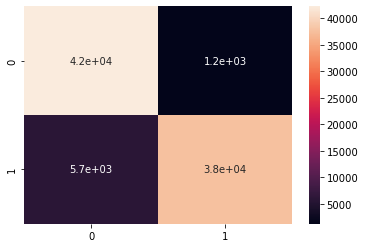

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_train_, infer>0.5)
sns.heatmap(cm, annot=True)

<AxesSubplot:>

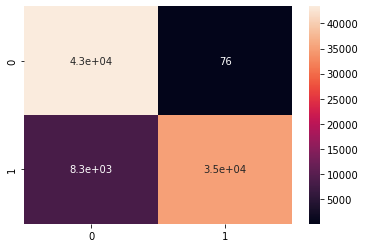

In [42]:
from sklearn.metrics import confusion_matrix
cm2 = confusion_matrix(y_train_, infer>0.9)
sns.heatmap(cm2, annot=True)

In [43]:
from sklearn.metrics import roc_curve
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_train_, infer)

In [44]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

In [45]:
np.save("results/false_positive_V_train", fpr_keras)
np.save("results/true_positive_V_train", tpr_keras)
np.save("results/thresholds_V_train", thresholds_keras)

In [46]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

# Valid

In [47]:
%%time
infer = model.predict(x_valid_, batch_size=4096)

CPU times: user 1.33 s, sys: 523 ms, total: 1.85 s
Wall time: 158 ms


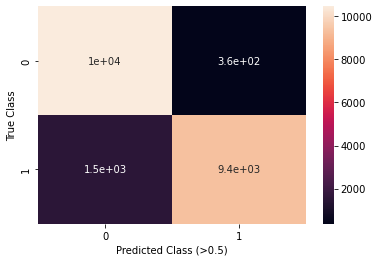

In [48]:
from sklearn.metrics import confusion_matrix
cmv = confusion_matrix(y_valid_, infer>0.5)
sns.heatmap(cmv, annot=True)
plt.xlabel("Predicted Class (>0.5)")
plt.ylabel("True Class")
plt.show()

<AxesSubplot:>

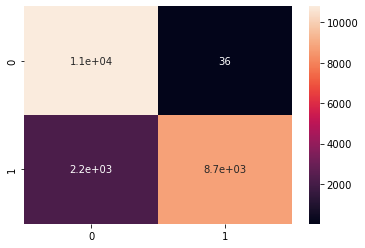

In [49]:
from sklearn.metrics import confusion_matrix
cmv2 = confusion_matrix(y_valid_, infer>0.9)
sns.heatmap(cmv2, annot=True)

In [50]:
from sklearn.metrics import roc_curve
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_valid_, infer)

In [51]:
np.save("results/false_positive_V_valid", fpr_keras)
np.save("results/true_positive_V_valid", tpr_keras)
np.save("results/thresholds_V_valid", thresholds_keras)

Text(0, 0.5, 'True Positive Rate')

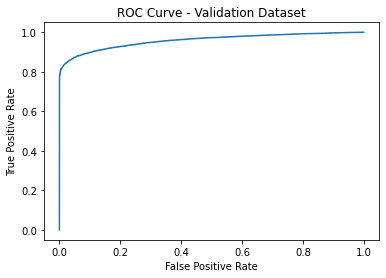

In [52]:
plt.plot(fpr_keras, tpr_keras)
plt.title("ROC Curve - Validation Dataset")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

# test

In [53]:
#%%time
#cc_infer = model.predict(cc_x_test_scaled, batch_size=4096)
#es_infer = model.predict(es_x_test_scaled, batch_size=4096)
all_infer = model.predict(x_test_scaled, batch_size=4096)
all_y_test = y_test


In [54]:
from sklearn.metrics import confusion_matrix
#cc1 = confusion_matrix(cc_y_test, cc_infer>0.5)
#sns.heatmap(cc1, annot=True)

In [55]:
#es1 = confusion_matrix(es_y_test, es_infer>0.5)
#sns.heatmap(es1, annot=True)

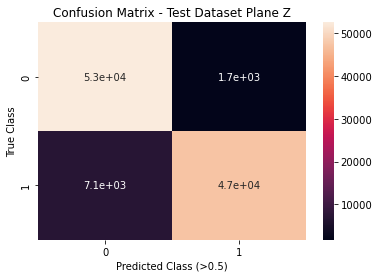

In [56]:
all1 = confusion_matrix(all_y_test, all_infer>0.5)
sns.heatmap(all1, annot=True)
plt.title("Confusion Matrix - Test Dataset Plane " + wireplane)
plt.xlabel("Predicted Class (>0.5)")
plt.ylabel("True Class")
plt.show()

In [57]:
from sklearn.metrics import confusion_matrix
#cc2 = confusion_matrix(cc_y_test, cc_infer>0.9)
#sns.heatmap(cc2, annot=True)

In [58]:
#es2 = confusion_matrix(es_y_test, es_infer>0.9)
#sns.heatmap(es2, annot=True)

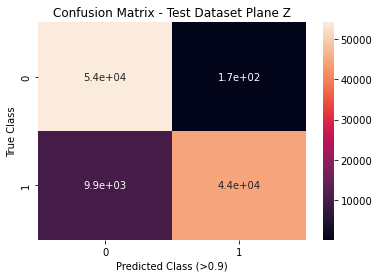

In [59]:
all2 = confusion_matrix(all_y_test, all_infer>0.9)
sns.heatmap(all2, annot=True)
plt.title("Confusion Matrix - Test Dataset Plane " + wireplane)
plt.xlabel("Predicted Class (>0.9)")
plt.ylabel("True Class")
plt.show()

In [60]:
from sklearn.metrics import roc_curve
#fpr_keras, tpr_keras, thresholds_keras = roc_curve(cc_y_test, cc_infer)
#plt.plot(fpr_keras, tpr_keras)

In [61]:
#fpr_keras, tpr_keras, thresholds_keras = roc_curve(es_y_test, es_infer)
#plt.plot(fpr_keras, tpr_keras)

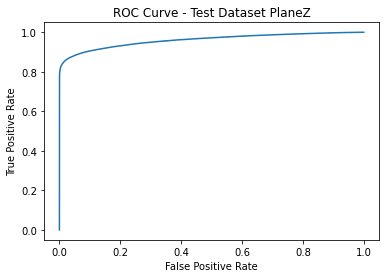

In [62]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(all_y_test, all_infer)
plt.plot(fpr_keras, tpr_keras)
plt.title("ROC Curve - Test Dataset Plane" + wireplane)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [63]:
np.save("results/false_positive_V_test", fpr_keras)
np.save("results/true_positive_V_test", tpr_keras)
np.save("results/thresholds_V_test", thresholds_keras)

In [64]:
#plt.hist(cc_infer, bins = 100);

In [65]:
#plt.hist(es_infer, bins = 100);

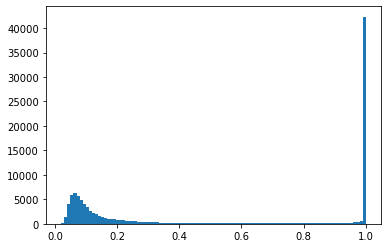

In [66]:
plt.hist(all_infer, bins = 100);

In [67]:
%%time
#cc_infer_signal = model.predict(cc_x_test_scaled[cc_y_test==1], batch_size=4096)
#cc_infer_noise = model.predict(cc_x_test_scaled[cc_y_test==0], batch_size=4096)
#es_infer_signal = model.predict(es_x_test_scaled[es_y_test==1], batch_size=4096)
#es_infer_noise = model.predict(es_x_test_scaled[es_y_test==0], batch_size=4096)
all_infer_signal = model.predict(x_test_scaled[y_test==1], batch_size=4096)
all_infer_noise = model.predict(x_test_scaled[y_test==0], batch_size=4096)

CPU times: user 6.47 s, sys: 3.11 s, total: 9.58 s
Wall time: 981 ms


In [68]:
#plt.hist(cc_infer_noise, range = (0,1), bins=20)

In [69]:
#plt.hist(es_infer_noise, range = (0,1), bins=20)

(array([ 5594., 25250., 10327.,  4585.,  2537.,  1572.,  1007.,   724.,
          555.,   434.,   327.,   284.,   221.,   176.,   161.,   137.,
          137.,   106.,    82.,    84.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ],
       dtype=float32),
 <BarContainer object of 20 artists>)

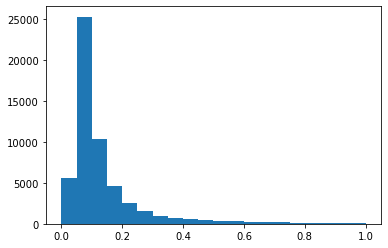

In [70]:
plt.hist(all_infer_noise, range = (0,1), bins=20)

In [71]:
#plt.hist(cc_infer_signal, range = (0,1), bins=20)

In [72]:
#plt.hist(es_infer_signal, range = (0,1), bins=20)

(array([  164.,  1708.,  1394.,  1010.,   689.,   530.,   485.,   419.,
          367.,   313.,   301.,   326.,   315.,   288.,   319.,   361.,
          391.,   505.,   737., 43678.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ],
       dtype=float32),
 <BarContainer object of 20 artists>)

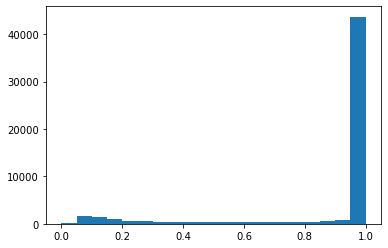

In [73]:
plt.hist(all_infer_signal, range = (0,1), bins=20)